# ДЗ №2

Сделать логистическую регрессию на известных признаках, получить как можно лучший `score` (использовать регулиризацию, подбор гиперпараметров)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
sns.set()

from math import floor

In [2]:
def cross_validation(train, features, target, scoring_metric='roc_auc', l1=None, solver='lbfgs', penalty='l2'):
    cv_results = cross_val_score(LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1), train[features], train[target].values.ravel(), cv=5, scoring=scoring_metric)
    
#     for i in range(len(cv_results)):
#         print(f'Fold #{i+1}: {round(cv_results[i], 5)}')
    score = np.mean(cv_results)
#     print( f'Average = {score}')
    
    return score

In [3]:
def train_and_save_model(train, test, features, target, nameFile, l1=None, solver='lbfgs', penalty='l2'):
    model = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1)
    model.fit(X=train[features], y = train[target].values.ravel())
    test_prediction = model.predict_proba(test[features])[:,1]
    sample_submission = pd.read_csv('../data/raw/HW#2/sample_submission.csv')
    sample_submission[target] = test_prediction
    #sample_submission[target] = sample_submission[target].clip(0, 1000000000)
    sample_submission.to_csv(f'HW#2_models/{nameFile}.csv', index = False)

In [4]:
def normalize(sequences):
    return (sequences - sequences.mean()) / (sequences.max() - sequences.min())

In [5]:
train = pd.read_csv('../data/raw/HW#2/application_train.csv')
test = pd.read_csv('../data/raw/HW#2/application_test.csv')

### Модель 0

In [6]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
target = ['TARGET']

In [7]:
train[features].isna().sum()

AMT_INCOME_TOTAL     0
AMT_CREDIT           0
AMT_ANNUITY         12
dtype: int64

In [8]:
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())

In [9]:
train[features].min()

AMT_INCOME_TOTAL    25650.0
AMT_CREDIT          45000.0
AMT_ANNUITY          1615.5
dtype: float64

In [10]:
train[features] /= 1000
test[features] /= 1000

In [11]:
cross_validation(train, features, target)

0.5327320455583101

In [12]:
train_and_save_model(train, test, features, target, 'model_0')

### Модель 1

In [13]:
train1 = train.copy()
test1 = test.copy()

In [14]:
train1[features] = normalize(train1[features])
test1[features] = normalize(test1[features])

In [15]:
cross_validation(train1, features, target)

0.5301784448570589

In [16]:
train_and_save_model(train1, test1, features, target, 'model_1')

### Модель 2

In [17]:
features += ['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR',
             'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']

In [18]:
train[features]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CODE_GENDER,FLAG_OWN_REALTY,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE
0,202.5,406.5975,24.7005,M,Y,N,Secondary / secondary special,Single / not married,Working
1,270.0,1293.5025,35.6985,F,N,N,Higher education,Married,State servant
2,67.5,135.0000,6.7500,M,Y,Y,Secondary / secondary special,Single / not married,Working
3,135.0,312.6825,29.6865,F,Y,N,Secondary / secondary special,Civil marriage,Working
4,121.5,513.0000,21.8655,M,Y,N,Secondary / secondary special,Single / not married,Working
...,...,...,...,...,...,...,...,...,...
307506,157.5,254.7000,27.5580,M,N,N,Secondary / secondary special,Separated,Working
307507,72.0,269.5500,12.0015,F,Y,N,Secondary / secondary special,Widow,Pensioner
307508,153.0,677.6640,29.9790,F,Y,N,Higher education,Separated,Working
307509,171.0,370.1070,20.2050,F,Y,N,Secondary / secondary special,Married,Commercial associate


In [19]:
train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [20]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })
test['CODE_GENDER'] = test['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })

In [21]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })

In [22]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })

In [23]:
dict_education = {'Secondary / secondary special': 1, 'Higher education': 3,
       'Incomplete higher': 2, 'Lower secondary': 0, 'Academic degree': 4}
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(dict_education)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(dict_education)

In [24]:
dict_family_stat = {'Single / not married': 0, 'Married': 2, 'Civil marriage': 1, 'Widow': 4,
       'Separated': 3, 'Unknown': 0 }
train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace(dict_family_stat)
test['NAME_FAMILY_STATUS'] = test['NAME_FAMILY_STATUS'].replace(dict_family_stat)

In [25]:
dict_income_type = {'Working': 3, 'State servant': 5, 'Commercial associate': 6, 'Pensioner': 7,
       'Unemployed': 0, 'Student': 1, 'Businessman': 4, 'Maternity leave': 2}
train['NAME_INCOME_TYPE'] = train['NAME_INCOME_TYPE'].replace(dict_income_type)
test['NAME_INCOME_TYPE'] = test['NAME_INCOME_TYPE'].replace(dict_income_type)

In [26]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [27]:
cross_validation(train, features, target)

0.6128664921664913

In [28]:
train_and_save_model(train, test, features, target, 'model_2')

### Модель 3

In [29]:
def proc_categories(train, test, column_name):
    K = train.groupby([column_name]).size()
    mean_y = train.groupby([column_name])[column_name].mean()
    global_mean_y = train[column_name].mean()
    train[column_name] = (mean_y * K + global_mean_y * 10) / (K + 10)
    test[column_name] = (mean_y * K + global_mean_y * 10) / (K + 10)
    
    return train, test

In [30]:
# train, test = proc_categories(train, test, 'NAME_EDUCATION_TYPE')
# train, test = proc_categories(train, test, 'NAME_INCOME_TYPE')

In [31]:
# cross_validation(train, features, target)

In [32]:
# train_and_save_model(train, test, features, target, 'model_3')

### Модель 4

In [33]:
features += ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']

In [34]:
train['DAYS_REGISTRATION'] = train['DAYS_REGISTRATION'] / 365
train['DAYS_ID_PUBLISH'] = train['DAYS_ID_PUBLISH'] / 365
train['DAYS_BIRTH'] = train['DAYS_REGISTRATION'] / 365

In [35]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [36]:
cross_validation(train, features, target)

0.6271887889701484

In [37]:
train_and_save_model(train, test, features, target, 'model_4')

### Модель 5

In [38]:
features

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CODE_GENDER',
 'FLAG_OWN_REALTY',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH']

In [39]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [40]:
train[features]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CODE_GENDER,FLAG_OWN_REALTY,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_BIRTH
0,0.000288,-0.048047,-0.009391,0.658357,0.306327,-0.340108,-0.127377,-0.444131,-0.222806,0.054236,0.121468,0.054236
1,0.000865,0.173402,0.033501,-0.341643,-0.693673,-0.340108,0.372623,0.055869,0.062908,0.154026,0.375601,0.154026
2,-0.000866,-0.115862,-0.079398,0.658357,0.306327,0.659892,-0.127377,-0.444131,-0.222806,0.029431,0.064360,0.029431
3,-0.000289,-0.071497,0.010054,-0.341643,0.306327,-0.340108,-0.127377,-0.194131,-0.222806,-0.196453,0.077421,-0.196453
4,-0.000404,-0.021480,-0.020448,0.658357,0.306327,-0.340108,-0.127377,-0.444131,-0.222806,0.027364,-0.064443,0.027364
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.000097,-0.085974,0.001753,0.658357,-0.693673,-0.340108,-0.127377,0.305869,-0.222806,-0.140640,0.140642,-0.140640
307507,-0.000828,-0.082266,-0.058917,-0.341643,0.306327,-0.340108,-0.127377,0.555869,0.348622,0.024243,-0.152258,0.024243
307508,-0.000135,0.019635,0.011195,-0.341643,0.306327,-0.340108,0.372623,0.305869,-0.222806,-0.070966,-0.299541,-0.070966
307509,0.000019,-0.057158,-0.026924,-0.341643,0.306327,-0.340108,-0.127377,0.055869,0.205765,0.098254,0.286675,0.098254


In [44]:
l1_best = 0.1
max_score = 0.0
for i in range (10):
    res = cross_validation(train, features, target, l1=0.1 * i, solver='saga', penalty='elasticnet')
    print(f'Score = {res}, l1 = {0.1 * i}')
    if (res > max_score):
        max_score = res
        l1_best = 0.1 * i
        
print(f'Max Score = {max_score}, l1 = {l1_best}')

Score = 0.6271704889630633, l1 = 0.0
Score = 0.6271722331178166, l1 = 0.1
Score = 0.6271744453749638, l1 = 0.2
Score = 0.6271773701107577, l1 = 0.30000000000000004
Score = 0.6271794754728106, l1 = 0.4
Score = 0.6271830300180964, l1 = 0.5
Score = 0.627188121366759, l1 = 0.6000000000000001
Score = 0.6271916431338722, l1 = 0.7000000000000001
Score = 0.6271912519729743, l1 = 0.8
Score = 0.627191360975479, l1 = 0.9
Max Score = 0.6271916431338722, l1 = 0.7000000000000001


In [43]:
train_and_save_model(train, test, features, target, 'model_5', l1=l1_best, solver='saga', penalty='elasticnet')

### Итоги
Модели:

0. Score(private) - 0.53786, Score(public) - 0.55338, cv - 0.53273
1. Score(private) - 0.51821, Score(public) - 0.53444, cv - 0.53017
2. Score(private) - 0.61634, Score(public) - 0.61430, cv - 0.61286
3. -
4. Score(private) - 0.63189, Score(public) - 0.63142, cv - 0.62718
5. Score(private) - 0.63189, Score(public) - 0.63143, cv - 0.62719

No handles with labels found to put in legend.


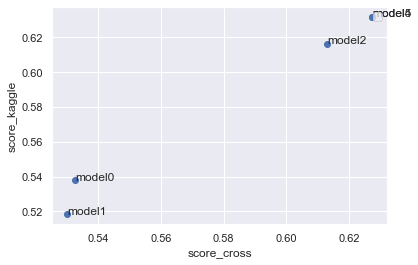

In [47]:
df = pd.DataFrame()
df['score_cross_val'] = [0.53273, 0.53017, 0.61286, 0.62718, 0.62719]
df['score_kaggle'] = [0.53786, 0.51821, 0.61634, 0.63189, 0.63189]
df['model'] = ['model0', 'model1', 'model2', 'model4', 'model5']

fig, ax = plt.subplots()
ax.scatter(df['score_cross_val'], df['score_kaggle'])

for i, txt in enumerate(df['model']):
    ax.annotate(txt, (df['score_cross_val'][i], df['score_kaggle'][i]))

# plt.plot(df['score_cross_val'], df['score_kaggle'])
plt.xlabel('score_cross')
plt.ylabel('score_kaggle')
plt.legend()
plt.show()

### Вывод
Самой лучшей моделью оказалась модель №5 с нормированными параметрами. Cross-validation была правильно настроена, так как показывает схожие результаты с kaggle. С помощью регуляризации и изменения гиперпараметров незначительно улучшился score на public данных kaggle. 